# The 2D Ising Model with Different Connectivity

In [1]:
"""Author: Steve Chadwick"""

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time
import numpy as np

# Supporting Code 

In [2]:
def createAlignedState(N,dim):
    #a single row vector of N^d ones
    return np.ones(N**dim)

def createRandomState(N,dim):
    #a row vector of N^d random -1 or 1's
    return 2*np.random.randint(2,size=[N**dim])-1

def calcTotalEnergy(state,adj):
    #this is State * Adjacency Matrix * State transpose.
    #simple matrix multiplication finds the energy, since the adjacency neighbor connects neighbors!
    return -np.dot(np.dot(state,adj),state)/2

def pickRandomSite(N,dim):
    return np.random.randint(N**dim)

def asymmetryGroups(N, totalN):
    """this function breaks up N sites into two groups such that the first N go in group A and the second N sites go
    in group B and the following N sites go in group A, and so on. This will be called in the process of creating the
    triangular matrix to deal with the asymmetry of a triangular lattice in cubic form."""
    A = []
    B = []
    lst = [i for i in range(totalN)]
    sublists = [lst[i:i+N] for i in range(0, len(lst), N)] #breaks up list into group of every other N elements
    
    for i in range(len(sublists)):  # puts all the even sublists into one group and all the odd sublist...
        if i % 2 == 0:              # ... into another group
            A.append(sublists[i])
        else:
            B.append(sublists[i])
    
    condensedA = [j for i in A for j in i]
    condensedB = [j for i in B for j in i]
    return condensedA, condensedB

""" These four edge detections deal with the four different edge cases in the triangle lattice. They are called
to handle the diagonal component of each edge case"""
def edgeDetection1(currSite, numSiteDim):
    x = (currSite+1)%numSiteDim
    if x > 0:
        return 1
    else:
        return 0

def edgeDetection2(currSite, numSiteDim):
    x = (currSite+1)%numSiteDim
    if x > 0:
        return 0
    else:
        return 1
def edgeDetection3(currSite, numSiteDim):
    x = (currSite)%numSiteDim
    if x > 0:
        return 1
    else:
        return 0

def edgeDetection4(currSite, numSiteDim):
    x = (currSite)%numSiteDim
    if x > 0:
        return 0
    else:
        return 1

# The Cubic Adjacency Matrix

In [3]:
def createCubicAdjacencyMatrix(N,dim):
    
    #the total number of sites
    totalN=N**dim
    
    #initialize as all 0's
    #the adjacency matrix is always 2D
    adj=np.zeros([totalN,totalN])
    
    #iterate through all the sites, and all the dimensions
    for currSite in range(totalN):
        for currDim in range(dim):
            #this is the distance, in indices, that a neighbor will be away from you in that dimension
            numSiteDim=N**currDim
            #this is the number of indices in the row, plane, etc that you will have to modulo by. 
            numSiteMod=N**(currDim+1)
            
            #one for currSite+numSiteDim as down or to the right, etc, with one for currSite-numSiteDim
            #as up or to the left, etc.
            #you need to modulo by the size of that dimension to find if you are on a boundary,
            #but then you need to add it back to get back to the interior of the other directions
            adj[currSite,(currSite+numSiteDim)%numSiteMod+int(np.floor(currSite/numSiteMod)*numSiteMod)]=1
            adj[currSite,(currSite-numSiteDim)%numSiteMod+int(np.floor(currSite/numSiteMod)*numSiteMod)]=1
    return adj

Text(0.5,1,'10x10 Cubic Adjacency Matrix')

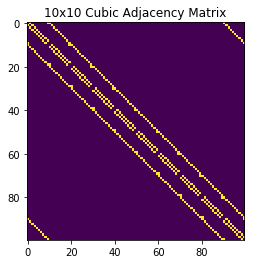

In [4]:
# 10x10 2D cubic adjacency matrix
adjCubic = createCubicAdjacencyMatrix(10,2)
plt.imshow(adjCubic)
plt.title("10x10 Cubic Adjacency Matrix")

# The Next Nearest Neighbor Adjacency Matrix

In [5]:
def NNNadjND(N, dim):
    """This creates the correct next nearest neighbor matrix for 1D and creates something similar to the 2D next
    nearest neighbor. My original goal was only to solve this for 1D but since my other matrices are in 2D I
    will use this and call it a NNN matrix. The 2D version of this created here is every site is connected to the next
    two sites in each direction.
    I only realized that my conception of NNN for 2D was wrong late in this
    project and with more time I would fix this, but since this is just an exploration I will leave it for now."""
    
    #the total number of sites
    totalN=N**dim
    
    #initialize as all 0's
    #the adjacency matrix is always 2D
    adj=np.zeros([totalN,totalN])
    
    #iterate through all the sites, and all the dimensions
    for currSite in range(totalN):
        for currDim in range(dim):
            #this is the distance, in indices, that a neighbor will be away from you in that dimension
            numSiteDim=N**currDim
            #this is the number of indices in the row, plane, etc that you will have to modulo by. 
            numSiteMod=N**(currDim+1)
            
            #one for currSite+numSiteDim as down or to the right, etc, with one for currSite-numSiteDim
            #as up or to the left, etc.
            #you need to modulo by the size of that dimension to find if you are on a boundary,
            #but then you need to add it back to get back to the interior of the other directions
            adj[currSite,(currSite+numSiteDim)%numSiteMod+int(np.floor(currSite/numSiteMod)*numSiteMod)]=1
            adj[currSite,(currSite-numSiteDim)%numSiteMod+int(np.floor(currSite/numSiteMod)*numSiteMod)]=1
            # This is the same as the cubic adj but adds one more neighbor per inital neighbor
            adj[currSite,(currSite+ (2*numSiteDim))%numSiteMod+int(np.floor(currSite/numSiteMod)*numSiteMod)]=1
            adj[currSite,(currSite- (2*numSiteDim))%numSiteMod+int(np.floor(currSite/numSiteMod)*numSiteMod)]=1
    return adj

Text(0.5,1,'10x10 NNN Adjacency Matrix')

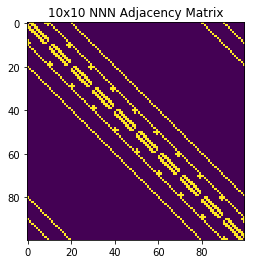

In [6]:
# 10x10 2D next nearest neighbor adjacency matrix
adjNNN = NNNadjND(10, 2)
plt.imshow(adjNNN)
plt.title("10x10 NNN Adjacency Matrix")

# The Triangular Adjacency Matrix

In [7]:
def createTriAdjacencyMatrix(N):
    """this creates a triangular adjacency matrix for 2D"""
    #The triangle lattice only works in 2D.
    dim = 2
    #the total number of sites
    totalN=N**dim
    
    #initialize as all 0's
    #the adjacency matrix is always 2D
    adj=np.zeros([totalN,totalN])
    
    """To preserve periodic boundary conditions on a square grid I chose an asymetric version of the triangular 
    lattice, but every other row is symmetric so I only need two groups of every other row"""
    A, B = asymmetryGroups(N, totalN)
    
    # The left and right connections are the same as the cubic matrix so this is the same and set up for 2D
    for currSite in range(totalN):
        numSiteDim=N**0
        numSiteMod=N**(0+1)

        adj[currSite,(currSite+numSiteDim)%numSiteMod+int(np.floor(currSite/numSiteMod)*numSiteMod)]=1
        adj[currSite,(currSite-numSiteDim)%numSiteMod+int(np.floor(currSite/numSiteMod)*numSiteMod)]=1
    
    # This adds the up and down connection, the same as cubic, but also adds the up one right one connnection and the
    # down one left one connection.
    for currSite in B:
        numSiteDim1=N**1
        numSiteMod1=N**(1+1)

        adj[currSite,(currSite+N)%numSiteMod1]=1
        adj[currSite,(currSite-N)%numSiteMod1]=1
        adj[currSite,(currSite + 1 + (N * edgeDetection1(currSite, N)))%numSiteMod1]=1
        adj[currSite,(currSite - N + 1 + (-N * edgeDetection2(currSite, N)))%numSiteMod1]=1
        
    # This adds the up and down connection, the same as cubic, but also adds the up one left one connnection and the
    # down one right one connection.
    for currSite in A:
        numSiteDim1=N**1
        #this is the number of indices in the row, plane, etc that you will have to modulo by. 
        numSiteMod1=N**(1+1)

        #one for currSite+numSiteDim as down or to the right, etc, with one for currSite-numSiteDim
        #as up or to the left, etc.
        #you need to modulo by the size of that dimension to find if you are on a boundary,
        #but then you need to add it back to get back to the interior of the other directions
        adj[currSite,(currSite+N)%numSiteMod1]=1
        adj[currSite,(currSite-N)%numSiteMod1]=1
        adj[currSite,(currSite - 1 + (-N * edgeDetection3(currSite, numSiteDim1)))%numSiteMod1]=1
        adj[currSite,(currSite + N - 1 + (N * edgeDetection4(currSite, numSiteDim1)))%numSiteMod1]=1
        
    return adj

Text(0.5,1,'10x10 Triangular Adjacency Matrix')

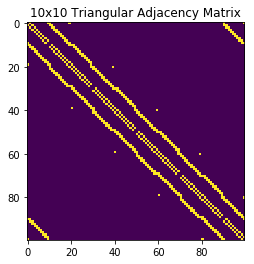

In [8]:
# 10x10 triangular adjacency matrix
adjTri = createTriAdjacencyMatrix(10)
plt.imshow(adjTri)
plt.title("10x10 Triangular Adjacency Matrix")

# The Hexagonal Adjacency Matrix

In [9]:
def createHexAdjacencyMatrix(N):
    """ This creates a hexagonal adjacency matrix. Since this uses periodic boundary conditions this only
    makes sense for even values of N and 2 dimensions"""
    
    dim = 2
    totalN = N**dim

    adj = np.zeros([totalN, totalN])
    
    # We'll again break up our asymmetric graph into two groups.
    A, B = asymmetryGroups(N, totalN)
    
    # To avoid returning a non periodic graph we will make sure N is even.
    if N % 2 != 0:
        return('Make N an even number to satisfy periodic boundary conditions.')
    
    else:
        """Here I break up the subgroups into even and odd sites since the patteren alternates a +1 and -1 
        left-right connection when viewed as a square lattice. Much of this code is the same as the cubic 
        matrix but with subtle changes."""
        for currSite in A:
            if currSite % 2 == 0:
                for currDim in range(dim):
                    #this is the distance, in indices, that a neighbor will be away from you in that dimension
                    numSiteDim=N**currDim
                    #this is the number of indices in the row, plane, etc that you will have to modulo by.
                    numSiteMod=N**(currDim+1)

                    if currDim == 0:
                        # this leaves out the left neighbor for every even connection in every other row
                        adj[currSite,(currSite+numSiteDim)%numSiteMod+int(np.floor(currSite/numSiteMod)*numSiteMod)]=1
                    elif currDim == 1:
                        adj[currSite,(currSite+numSiteDim)%numSiteMod+int(np.floor(currSite/numSiteMod)*numSiteMod)]=1
                        adj[currSite,(currSite-numSiteDim)%numSiteMod+int(np.floor(currSite/numSiteMod)*numSiteMod)]=1


            elif currSite % 2 == 1:
                for currDim in range(dim):
                    #this is the distance, in indices, that a neighbor will be away from you in that dimension
                    numSiteDim=N**currDim
                    #this is the number of indices in the row, plane, etc that you will have to modulo by. 
                    numSiteMod=N**(currDim+1)

                    if currDim == 0:
                        # this leaves out the right neighbor for every other odd connection in every other row
                        adj[currSite,(currSite-numSiteDim)%numSiteMod+int(np.floor(currSite/numSiteMod)*numSiteMod)]=1
                    elif currDim == 1:
                        adj[currSite,(currSite+numSiteDim)%numSiteMod+int(np.floor(currSite/numSiteMod)*numSiteMod)]=1
                        adj[currSite,(currSite-numSiteDim)%numSiteMod+int(np.floor(currSite/numSiteMod)*numSiteMod)]=1
                        
        for currSite in B:
            if currSite % 2 == 0:
                for currDim in range(dim):
                    #this is the distance, in indices, that a neighbor will be away from you in that dimension
                    numSiteDim=N**currDim
                    #this is the number of indices in the row, plane, etc that you will have to modulo by. 
                    numSiteMod=N**(currDim+1)
                    
                    if currDim == 0:
                        # this leaves out the right neighbor for every other even connection in every other row
                        adj[currSite,(currSite-numSiteDim)%numSiteMod+int(np.floor(currSite/numSiteMod)*numSiteMod)]=1
                    elif currDim == 1:
                        adj[currSite,(currSite+numSiteDim)%numSiteMod+int(np.floor(currSite/numSiteMod)*numSiteMod)]=1
                        adj[currSite,(currSite-numSiteDim)%numSiteMod+int(np.floor(currSite/numSiteMod)*numSiteMod)]=1


            elif currSite % 2 == 1:
                for currDim in range(dim):
                    #this is the distance, in indices, that a neighbor will be away from you in that dimension
                    numSiteDim=N**currDim
                    #this is the number of indices in the row, plane, etc that you will have to modulo by. 
                    numSiteMod=N**(currDim+1)

                    if currDim == 0:
                        # this leaves out the left neighbor for every other odd connection in every other row
                        adj[currSite,(currSite+numSiteDim)%numSiteMod+int(np.floor(currSite/numSiteMod)*numSiteMod)]=1
                    elif currDim == 1:
                        adj[currSite,(currSite+numSiteDim)%numSiteMod+int(np.floor(currSite/numSiteMod)*numSiteMod)]=1
                        adj[currSite,(currSite-numSiteDim)%numSiteMod+int(np.floor(currSite/numSiteMod)*numSiteMod)]=1
    return adj

Text(0.5,1,'10x10 Hexagonal Adjacency Matrix')

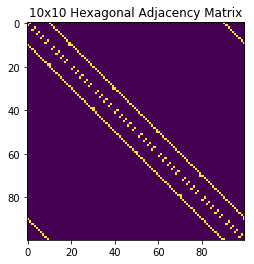

In [10]:
# 10x10 Hexagonal adjacency matrix
adjHex = createHexAdjacencyMatrix(10)
plt.imshow(adjHex)
plt.title("10x10 Hexagonal Adjacency Matrix")

# The Erdos Renyi Adjacency Matrix

In [11]:
def ErdosRenyiAdjacencyMatrix(N, p):
    """This creates a graph were each edge between a node is random and its likelyhood is 
    dependent on probablity p. This is designed for 2D.
    p should be between 0 and 1."""
    
    #This deals with unreasonable p values.
    if p > 1 or p < 0:
        return 'Probablity p must be between 0 and 1.'
    
    dim = 2
    totalN = N**dim

    adj = np.zeros([totalN, totalN])
    
    #this iterates through every site
    for currSite in range(totalN):
        #this iterates through all the uncheck possible edges
        for node in range(currSite + 1,totalN):
            randomP = np.random.random()
            
            #this connects the currSite and the node with probablity p.
            if randomP <= p:
                
                adj[currSite, node] = 1
                adj[node, currSite] = 1
    return adj

Text(0.5,1,'10x10 Erdos Renyi Adjacency Matrix')

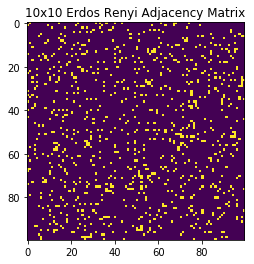

In [33]:
# 10x10 Erdos Renyi adjacency matrix with 2*2*ln(10)/10 probablity. 
#if p = 2*ln(10)/10, as N**2 goes to infinity the probablity of a connected graph goes to 1
adjER = ErdosRenyiAdjacencyMatrix(10, .092103)
plt.imshow(adjER)
plt.title("10x10 Erdos Renyi Adjacency Matrix")

# Ising Model & Physical Characteristics

In [13]:
def calcDeltaE(state,adj,site):
    neighbors=adj[site,:]
    deltaE=2*state[site]*np.sum(state*neighbors)
    return deltaE

def isingND(state, adjacencyMatrix, N, dim, T, nSteps):
    
    E = np.zeros(nSteps)
    mag = np.zeros(nSteps)  # sets up an empty matrix for the average state of each iteration
    E[0] = calcTotalEnergy(state,adjacencyMatrix)
    mag[0] = stateMag(state)

    for t in range(1,nSteps):
        site = pickRandomSite(N,dim)        
        deltaE = calcDeltaE(state, adjacencyMatrix, site)
       
        #calculate the probability of flipping:
        if(deltaE<0):
            probabilityToFlip=1
        elif deltaE==0:
            probabilityToFlip=1/2
        #deltaE>0
        else:
            if T==0:
                probabilityToFlip=0
            else:
                probabilityToFlip=np.exp(-deltaE/T)
            
        #generate a random number, and use it to decide to flip the spin
        #here we are avoiding recalculating the energy at each time step!
        if(np.random.rand()<=probabilityToFlip):            
            state[site]*=-1
            E[t] = E[t-1] + deltaE
            mag[t] = stateMag(state)
        else:
            E[t] = E[t-1]
            mag[t] = mag[t-1]
    return state, E, mag

def lastNmean(E, n):
    """This function caclulates the average energy from the final n states for a given temperature,
    if E hasn't been iterated by at least n steps then this just returns an error message."""
    if len(E) >= n:
        lastN = np.split(E, [(len(E)-n),])  # splits array into two arrays, 
        lastN = lastN[1]                    # the second array is the final n elements
        mean = np.sum(lastN) / n
        return mean
    else:
        return "Error: E must have at least n elements; increase nSteps in isisngND."

def stateMag(state):
    return np.sum(state)

def variance(x, n):
    #this function finds the variance of matrix. This will be used to calculate the average squared minus the 
    #squared average.
    aveSquared = (lastNmean(x, n)) ** 2
    square = x ** 2
    squareAve = lastNmean(square, n)
    variance = squareAve - aveSquared
    return variance
    

# Statistics Based on Changing Temperature

In [14]:
def energyFromTempRange(N, dim, startT, endT, stepSize, adj):
    """ This function creates a list of the average energies as temperature changes from startT to endT.
    By default this calculates 7000 iterations of each state"""
    
    nStep = 8000
    n = 2000
    temp = []
    energy = []
    magnetization = []
    heatCap = []
    magSus = []
    for i in range(int(abs(endT-startT)//stepSize)):         #This finds the average energy of the last 2000
        if endT > startT:                                    #energies of the state at each temperature between
            t = startT + (i * stepSize)                      #startT and endT and appends them to a list.
        elif endT < startT:
            t = startT - (i * stepSize)                      #This deals with decreasing temperatures
        else:
            t = startT                                       #This deals with equal startT and endT.
            
                                                            
        state = createAlignedState(N,dim)                    
        adj = adj
        finalState, E, mag = isingND(state,adj,N,dim,t,nStep)
        averageE = lastNmean(E, n)
        averageMag = lastNmean(mag, n)
        heatCapacity = (1/(t**2))*variance(E, n)                #Here we multiply 1/T^2 and 1/T by the variance to find
        magneticSusceptibility = (1/(t**2))*variance(mag, n)         #the heat capacity and specific heat

        magnetization.append(averageMag)
        energy.append(averageE)
        temp.append(t)
        heatCap.append(heatCapacity)
        magSus.append(magneticSusceptibility)
    
    return temp, energy, magnetization, heatCap, magSus

# Global Variables

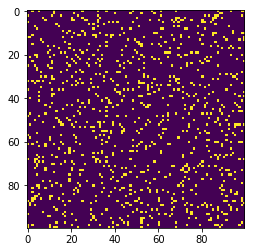

In [32]:
N = 10 
dim = 2 #do not change this, most adjacency matrices only work in 2D
startT =.5
endT = 10
stepSize = .1
p = .092103

adjCubic = createCubicAdjacencyMatrix(N,dim)
adjNNN = NNNadjND(N, dim)
adjTri = createTriAdjacencyMatrix(N)
adjHex = createHexAdjacencyMatrix(N)
adjER = ErdosRenyiAdjacencyMatrix(N, p)

cubic = energyFromTempRange(N, dim, startT, endT, stepSize, adjCubic)
NNN = energyFromTempRange(N, dim, startT, endT, stepSize, adjNNN)
triangular = energyFromTempRange(N, dim, startT, endT, stepSize, adjTri)
hexagonal = energyFromTempRange(N, dim, startT, endT, stepSize, adjHex)
ER = energyFromTempRange(N, dim, startT, endT, stepSize, adjER)

# since the Erdos Renyi graph changes this will display the graph associated with the graphs below
plt.imshow(adjER)

In [34]:
temp, energy1, mag1, heatCap1, magSus1 = cubic

In [35]:
temp, energy2, mag2, heatCap2, magSus2 = NNN

In [36]:
temp, energy3, mag3, heatCap3, magSus3 = triangular

In [37]:
temp, energy4, mag4, heatCap4, magSus4 = hexagonal

In [38]:
temp, energy5, mag5, heatCap5, magSus5 = ER

# Graphical Representations:

# Energy vs Time with Different Connectivity

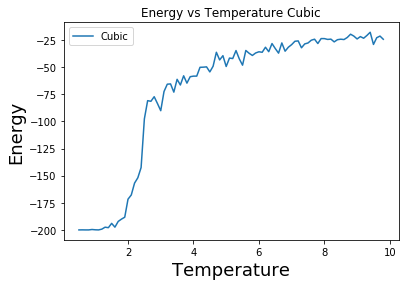

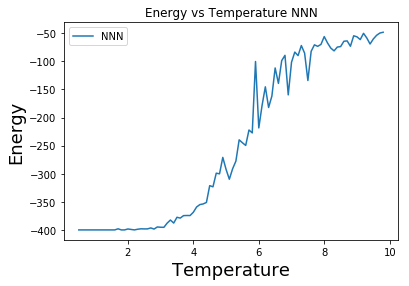

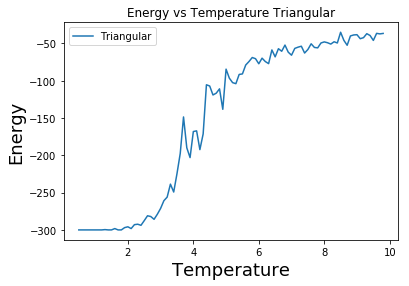

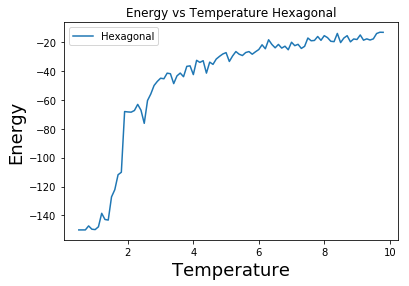

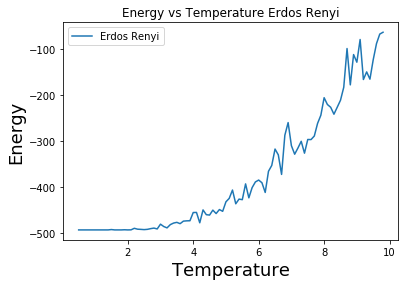

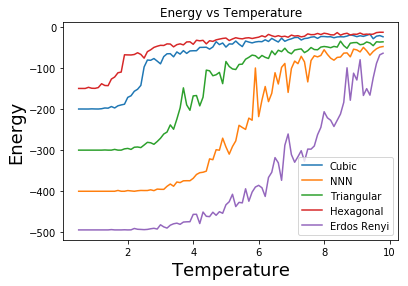

In [39]:
plt.plot(temp, energy1, label='Cubic')
plt.title("Energy vs Temperature Cubic")
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Energy', fontsize=18)
plt.legend()
plt.show()

plt.plot(temp, energy2, label='NNN')
plt.title("Energy vs Temperature NNN")
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Energy', fontsize=18)
plt.legend()
plt.show()

plt.plot(temp, energy3, label='Triangular')
plt.title("Energy vs Temperature Triangular")
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Energy', fontsize=18)
plt.legend()
plt.show()

plt.plot(temp, energy4, label='Hexagonal')
plt.title("Energy vs Temperature Hexagonal")
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Energy', fontsize=18)
plt.legend()
plt.show()

plt.plot(temp, energy5, label='Erdos Renyi')
plt.title("Energy vs Temperature Erdos Renyi")
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Energy', fontsize=18)
plt.legend()
plt.show()

plt.plot(temp, energy1, label='Cubic')
plt.plot(temp, energy2, label='NNN')
plt.plot(temp, energy3, label='Triangular')
plt.plot(temp, energy4, label='Hexagonal')
plt.plot(temp, energy5, label='Erdos Renyi')
plt.title("Energy vs Temperature")
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Energy', fontsize=18)
plt.legend()
plt.show()

# Magnetization vs Temperature with Different Connectivity

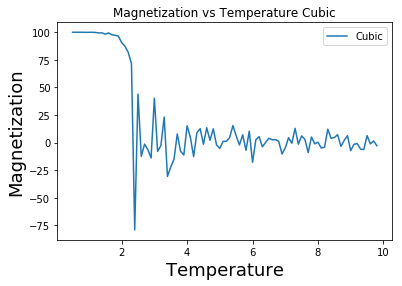

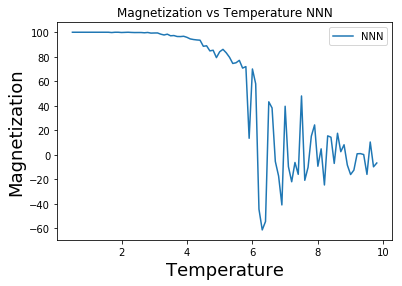

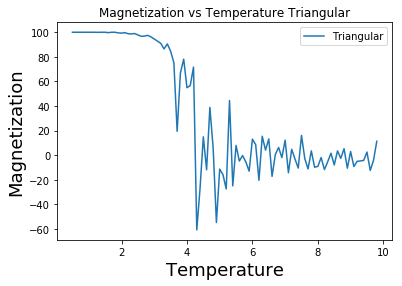

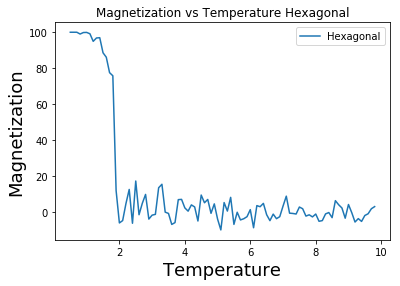

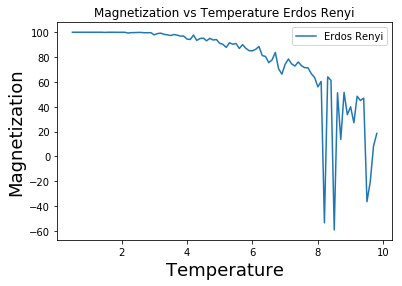

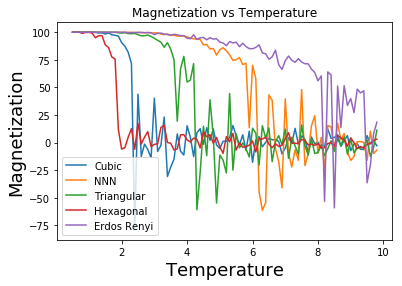

In [40]:
plt.plot(temp, mag1, label='Cubic')
plt.title("Magnetization vs Temperature Cubic")
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Magnetization', fontsize=18)
plt.legend()
plt.show()

plt.plot(temp, mag2, label='NNN')
plt.title("Magnetization vs Temperature NNN")
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Magnetization', fontsize=18)
plt.legend()
plt.show()

plt.plot(temp, mag3, label='Triangular')
plt.title("Magnetization vs Temperature Triangular")
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Magnetization', fontsize=18)
plt.legend()
plt.show()

plt.plot(temp, mag4, label='Hexagonal')
plt.title("Magnetization vs Temperature Hexagonal")
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Magnetization', fontsize=18)
plt.legend()
plt.show()

plt.plot(temp, mag5, label='Erdos Renyi')
plt.title("Magnetization vs Temperature Erdos Renyi")
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Magnetization', fontsize=18)
plt.legend()
plt.show()

plt.plot(temp, mag1, label='Cubic')
plt.plot(temp, mag2, label='NNN')
plt.plot(temp, mag3, label='Triangular')
plt.plot(temp, mag4, label='Hexagonal')
plt.plot(temp, mag5, label='Erdos Renyi')
plt.title("Magnetization vs Temperature")
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Magnetization', fontsize=18)
plt.legend()
plt.show()

# Heat Capacity vs Temperature with Different Connectivity

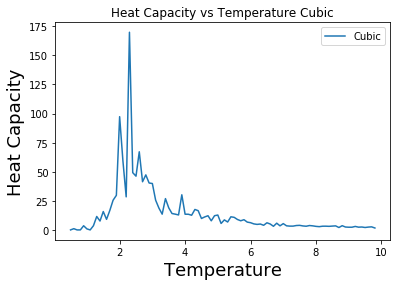

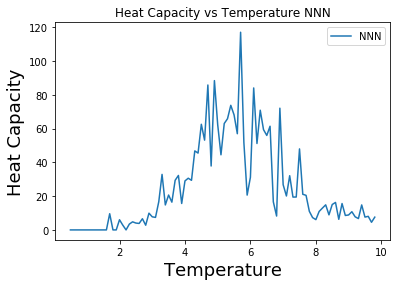

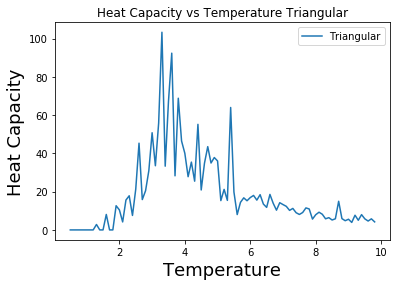

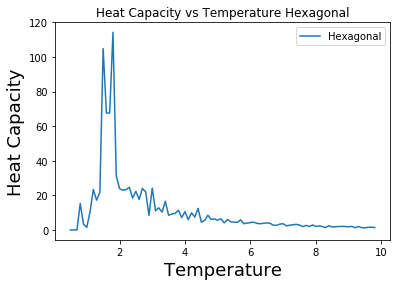

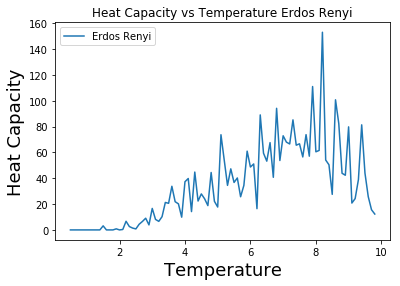

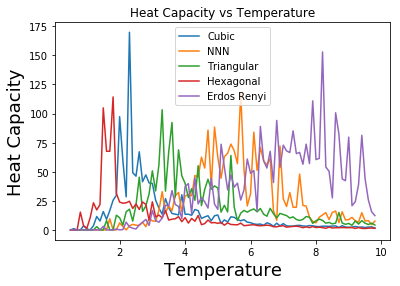

In [41]:
plt.plot(temp, heatCap1, label='Cubic')
plt.title("Heat Capacity vs Temperature Cubic")
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Heat Capacity', fontsize=18)
plt.legend()
plt.show()

plt.plot(temp, heatCap2, label='NNN')
plt.title("Heat Capacity vs Temperature NNN")
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Heat Capacity', fontsize=18)
plt.legend()
plt.show()

plt.plot(temp, heatCap3, label='Triangular')
plt.title("Heat Capacity vs Temperature Triangular")
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Heat Capacity', fontsize=18)
plt.legend()
plt.show()

plt.plot(temp, heatCap4, label='Hexagonal')
plt.title("Heat Capacity vs Temperature Hexagonal")
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Heat Capacity', fontsize=18)
plt.legend()
plt.show()

plt.plot(temp, heatCap5, label='Erdos Renyi')
plt.title("Heat Capacity vs Temperature Erdos Renyi")
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Heat Capacity', fontsize=18)
plt.legend()
plt.show()

plt.plot(temp, heatCap1, label='Cubic')
plt.plot(temp, heatCap2, label='NNN')
plt.plot(temp, heatCap3, label='Triangular')
plt.plot(temp, heatCap4, label='Hexagonal')
plt.plot(temp, heatCap5, label='Erdos Renyi')
plt.title("Heat Capacity vs Temperature")
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Heat Capacity', fontsize=18)
plt.legend()
plt.show()

# Magnetic Susceptibility vs Temperature with Different Connectivity

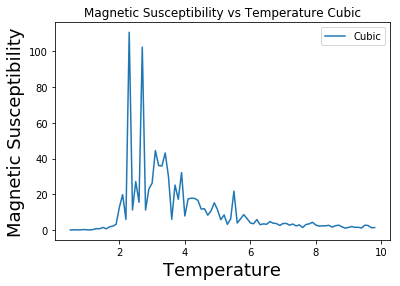

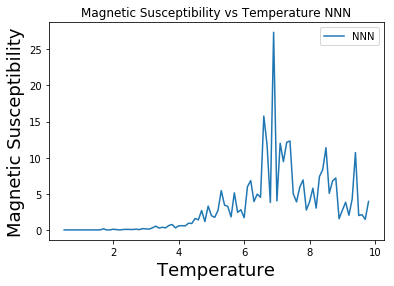

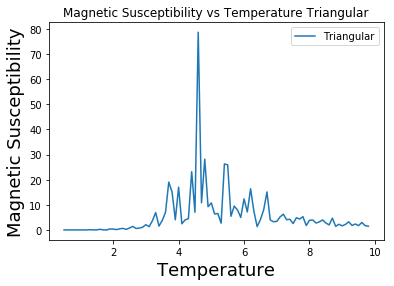

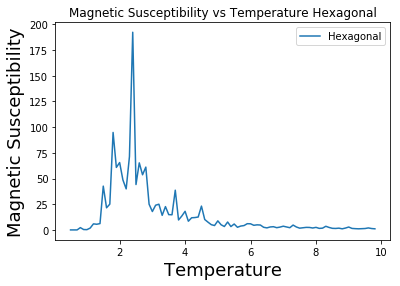

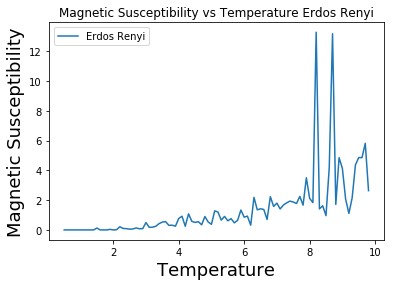

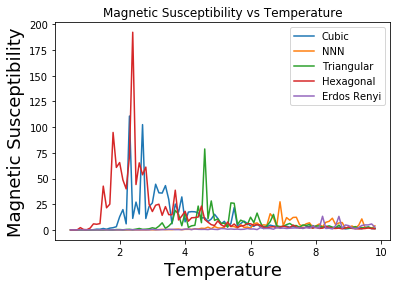

In [42]:
plt.plot(temp, magSus1, label='Cubic')
plt.title("Magnetic Susceptibility vs Temperature Cubic")
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Magnetic Susceptibility', fontsize=18)
plt.legend()
plt.show()

plt.plot(temp, magSus2, label='NNN')
plt.title("Magnetic Susceptibility vs Temperature NNN")
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Magnetic Susceptibility', fontsize=18)
plt.legend()
plt.show()

plt.plot(temp, magSus3, label='Triangular')
plt.title("Magnetic Susceptibility vs Temperature Triangular")
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Magnetic Susceptibility', fontsize=18)
plt.legend()
plt.show()

plt.plot(temp, magSus4, label='Hexagonal')
plt.title("Magnetic Susceptibility vs Temperature Hexagonal")
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Magnetic Susceptibility', fontsize=18)
plt.legend()
plt.show()

plt.plot(temp, magSus5, label='Erdos Renyi')
plt.title("Magnetic Susceptibility vs Temperature Erdos Renyi")
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Magnetic Susceptibility', fontsize=18)
plt.legend()
plt.show()

plt.plot(temp, magSus1, label='Cubic')
plt.plot(temp, magSus2, label='NNN')
plt.plot(temp, magSus3, label='Triangular')
plt.plot(temp, magSus4, label='Hexagonal')
plt.plot(temp, magSus5, label='Erdos Renyi')
plt.title("Magnetic Susceptibility vs Temperature")
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Magnetic Susceptibility', fontsize=18)
plt.legend()
plt.show()

# Critical Temperature with Erdos Renyi Connectivity and Changing p Values

In [43]:
N = 10 
dim = 2 #do not change this, most adjacency matrices only work in 2D
startT =.5
endT = 10
stepSize = .1
p1 = .1
p2 = .08
p3 = .06
p4 = .04
p5 = .02

adjER1 = ErdosRenyiAdjacencyMatrix(N, p1)
adjER2 = ErdosRenyiAdjacencyMatrix(N, p2)
adjER3 = ErdosRenyiAdjacencyMatrix(N, p3)
adjER4 = ErdosRenyiAdjacencyMatrix(N, p4)
adjER5 = ErdosRenyiAdjacencyMatrix(N, p5)

ER1 = energyFromTempRange(N, dim, startT, endT, stepSize, adjER1)
ER2 = energyFromTempRange(N, dim, startT, endT, stepSize, adjER2)
ER3 = energyFromTempRange(N, dim, startT, endT, stepSize, adjER3)
ER4 = energyFromTempRange(N, dim, startT, endT, stepSize, adjER4)
ER5 = energyFromTempRange(N, dim, startT, endT, stepSize, adjER5)

temp, energy6, mag6, heatCap6, magSus6 = ER1
temp, energy7, mag7, heatCap7, magSus7 = ER2
temp, energy8, mag8, heatCap8, magSus8 = ER3
temp, energy9, mag9, heatCap9, magSus9 = ER4
temp, energy10, mag10, heatCap10, magSus10 = ER5

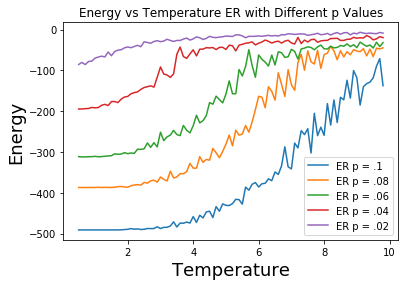

In [44]:
plt.plot(temp, energy6, label='ER p = .1')
plt.plot(temp, energy7, label='ER p = .08')
plt.plot(temp, energy8, label='ER p = .06')
plt.plot(temp, energy9, label='ER p = .04')
plt.plot(temp, energy10, label='ER p = .02')
plt.title("Energy vs Temperature ER with Different p Values")
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Energy', fontsize=18)
plt.legend()
plt.show()

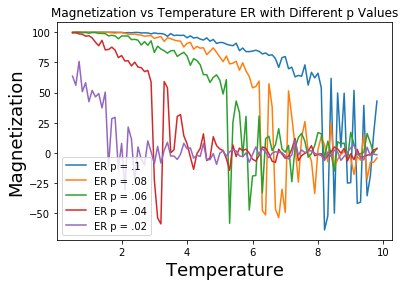

In [45]:
plt.plot(temp, mag6, label='ER p = .1')
plt.plot(temp, mag7, label='ER p = .08')
plt.plot(temp, mag8, label='ER p = .06')
plt.plot(temp, mag9, label='ER p = .04')
plt.plot(temp, mag10, label='ER p = .02')
plt.title("Magnetization vs Temperature ER with Different p Values")
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Magnetization', fontsize=18)
plt.legend()
plt.show()

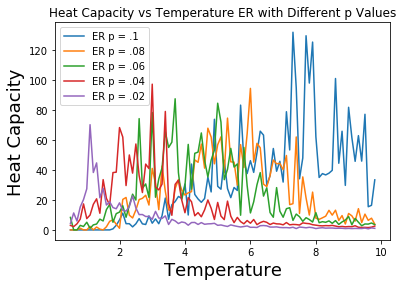

In [46]:
plt.plot(temp, heatCap6, label='ER p = .1')
plt.plot(temp, heatCap7, label='ER p = .08')
plt.plot(temp, heatCap8, label='ER p = .06')
plt.plot(temp, heatCap9, label='ER p = .04')
plt.plot(temp, heatCap10, label='ER p = .02')
plt.title("Heat Capacity vs Temperature ER with Different p Values")
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Heat Capacity', fontsize=18)
plt.legend()
plt.show()

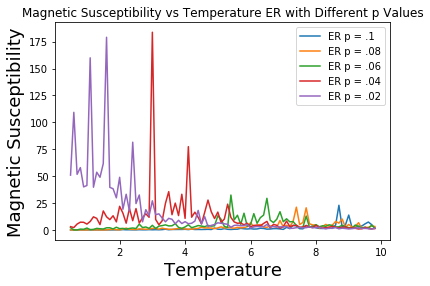

In [47]:
plt.plot(temp, magSus6, label='ER p = .1')
plt.plot(temp, magSus7, label='ER p = .08')
plt.plot(temp, magSus8, label='ER p = .06')
plt.plot(temp, magSus9, label='ER p = .04')
plt.plot(temp, magSus10, label='ER p = .02')
plt.title("Magnetic Susceptibility vs Temperature ER with Different p Values")
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Magnetic Susceptibility', fontsize=18)
plt.legend()
plt.show()